In [19]:
from foundry.util.runtime import setup
setup()

import foundry.core.tree as tree
import foundry.numpy as jnp

from foundry import core as F
from foundry.core.typing import Array
from foundry.data import Data, PyTreeData

In [20]:
import foundry.random

# raw_data = (jnp.array([-1., 1.]), jnp.array([-1., 1.]))
# raw_data : tuple[Array, Array] = tree.map(lambda x: jnp.repeat(x[None, :], 128, axis=0).reshape(-1), raw_data)

def sample(rng_key):
    x_rng, y_rng = foundry.random.split(rng_key)
    x = foundry.random.choice(x_rng, jnp.array([-1., 1.]))
    y = x + 0.1*foundry.random.normal(y_rng)
    return (x, y)
raw_data = F.vmap(sample)(foundry.random.split(foundry.random.key(42), 1024))
data = PyTreeData(raw_data)

In [21]:
import flax.linen as nn
from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation as activations
from typing import Any, Sequence

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    activation: str = "relu"
    time_embed_dim: int = 32

    @nn.compact
    def __call__(self, cond, value,
                    # either timestep or time_embed must be passed
                    timestep=None, train=False):
        activation = getattr(activations, self.activation)
        # works even if we have multiple timesteps
        timestep_flat = tree.ravel_pytree(timestep)[0] - 1
        time_embed = F.vmap(
            lambda x: SinusoidalPosEmbed(self.time_embed_dim)(x)
        )(timestep_flat).reshape(-1)
        time_embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            activation,
            nn.Dense(self.time_embed_dim),
        ])(time_embed)

        # concatenated embedding
        cond_flat, _ = tree.ravel_pytree(cond)
        value_flat, value_uf = tree.ravel_pytree(value)
        value = jnp.concatenate((value_flat, cond_flat), axis=-1)

        embed = time_embed
        for feat in self.features:
            shift, scale = jnp.split(nn.Dense(2*feat)(embed), 2, -1)
            value = activation(nn.Dense(feat)(value))
            value = value * (1 + scale) + shift
        value = nn.Dense(value_flat.shape[-1])(value)
        # x = jax.nn.tanh(x)
        value = value_uf(value)
        return value

model = DiffusionMLP(features=(16,16,16))

In [33]:
import optax
import foundry.train
from foundry.diffusion import DDPMSchedule

schedule = DDPMSchedule.make_squaredcos_cap_v2(
    100, 
    prediction_type="sample",
    clip_sample_range=2.,
)

def loss(vars, rng_key, sample):
    x, y = sample
    denoiser = lambda rng_key, noised_y, t: model.apply(vars, x, noised_y, t)
    loss = schedule.loss(rng_key, denoiser, y)
    return foundry.train.LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )
batch_loss = foundry.train.batch_loss(loss)

vars = model.init(foundry.random.key(42), 
    jnp.zeros(()), jnp.zeros(()),  0
)
iterations = 20_000
optimizer = optax.adamw(
    optax.cosine_decay_schedule(5e-3, iterations),
    weight_decay=0.001
)
ema = optax.ema(0.9)
opt_state = optimizer.init(vars["params"])
ema_state = ema.init(vars)
ema_update = F.jit(ema.update)

stream = data.stream().shuffle(foundry.random.key(42)).batch(512)
with foundry.train.loop(stream, iterations=iterations, progress=False,
        rng_key=foundry.random.key(40)) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, vars, metrics = foundry.train.step(batch_loss,
                optimizer, opt_state, vars, step.rng_key,
                step.batch
            )
            _, ema_state = ema_update(vars, ema_state)
            if (step.iteration + 1) % 1000 == 0 or step.iteration == 0:
                print(f"Iteration {step.iteration + 1}: {metrics['loss'].item()}")
vars = ema_state.ema

Iteration 1: 1.2339026927947998
Iteration 1000: 0.00918574444949627
Iteration 2000: 0.008092625066637993
Iteration 3000: 0.008516800589859486
Iteration 4000: 0.008611219003796577
Iteration 5000: 0.009031100198626518
Iteration 6000: 0.008922779932618141
Iteration 7000: 0.008570145815610886
Iteration 8000: 0.009209624491631985
Iteration 9000: 0.009081131778657436
Iteration 10000: 0.007975778542459011
Iteration 11000: 0.00859377346932888
Iteration 12000: 0.008786335587501526
Iteration 13000: 0.00849361065775156
Iteration 14000: 0.008968916721642017
Iteration 15000: 0.008592994883656502
Iteration 16000: 0.00867871381342411
Iteration 17000: 0.00876091793179512
Iteration 18000: 0.008230268955230713
Iteration 19000: 0.008703338913619518
Iteration 20000: 0.00784989632666111


In [34]:
from functools import partial
import foundry.random
from foundry.diffusion import nonparametric

xs = jnp.linspace(-1, 1, 1000)
nn_denoiser = lambda x, rng_key, y, t: model.apply(vars, x, y, t)

def sample(denoiser, x, rng_key):
    sample, trajectory = schedule.sample(rng_key, partial(denoiser, x), jnp.zeros(()), trajectory=True)
    Ts = jnp.arange(0, trajectory.shape[0]) + 1
    denoised_trajectory = F.vmap(lambda y, t:
        schedule.denoised_from_output(
            y, t,
            denoiser(x, None, y, t)
        )
    )(trajectory, Ts)
    # denoised_trajectory = trajectory
    return x, sample, trajectory, denoised_trajectory

nn_samples = F.vmap(
    lambda x, rng_key: sample(nn_denoiser, x, rng_key)
)(xs, foundry.random.split(foundry.random.key(42), tree.axis_size(xs, 0)))

nw_denoiser = lambda x, rng_key, noised_y, t: nonparametric.nw_cond_diffuser(
    x, 
    nn_samples[:2], schedule, 
    nonparametric.log_gaussian_kernel, 0.0001
)(rng_key, noised_y, t)
nw_samples = F.vmap(
    lambda x, rng_key: sample(nw_denoiser, x, rng_key)
)(xs, foundry.random.split(foundry.random.key(42), tree.axis_size(xs, 0)))

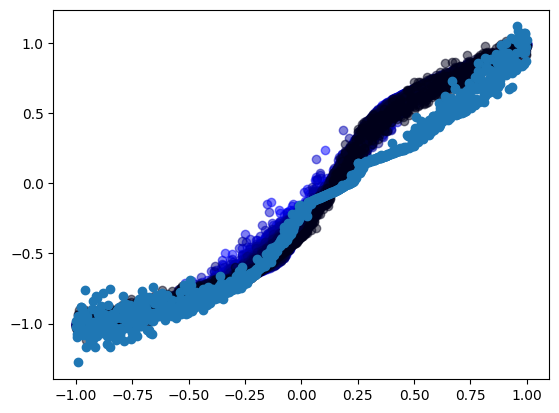

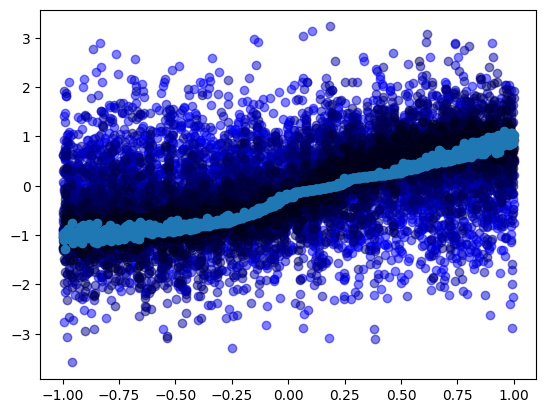

In [35]:
import matplotlib.pyplot as plt

plt.clf()
for i in range(100, 0, -10):
    plt.scatter(nn_samples[0], nn_samples[3][:,i], alpha=0.5, color=(0, 0, i/100))
plt.scatter(nn_samples[0], nn_samples[1])
plt.show()
plt.clf()
for i in range(100, 0, -10):
    plt.scatter(nn_samples[0], nn_samples[2][:,i], alpha=0.5, color=(0, 0, i/100))
plt.scatter(nn_samples[0], nn_samples[1])
plt.show()

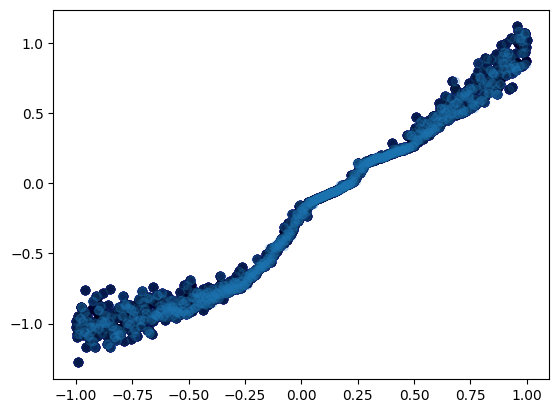

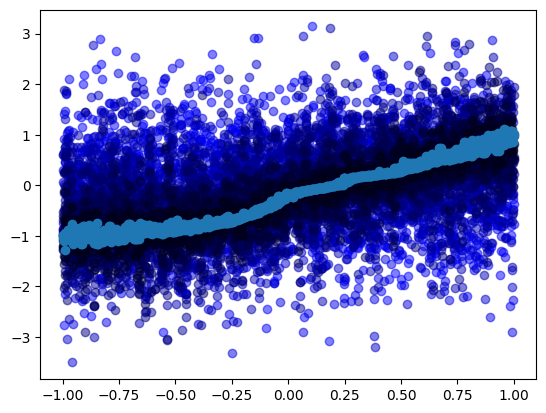

In [37]:
plt.clf()
for i in range(100, 0, -10):
    plt.scatter(nw_samples[0], nw_samples[3][:,i], alpha=0.5, color=(0, 0, i/100))
plt.scatter(nw_samples[0], nw_samples[1], alpha=0.2)
plt.show()
plt.clf()
for i in range(100, 0, -10):
    plt.scatter(nw_samples[0], nw_samples[2][:,i], alpha=0.5, color=(0, 0, i/100))
plt.scatter(nw_samples[0], nw_samples[1])
plt.show()


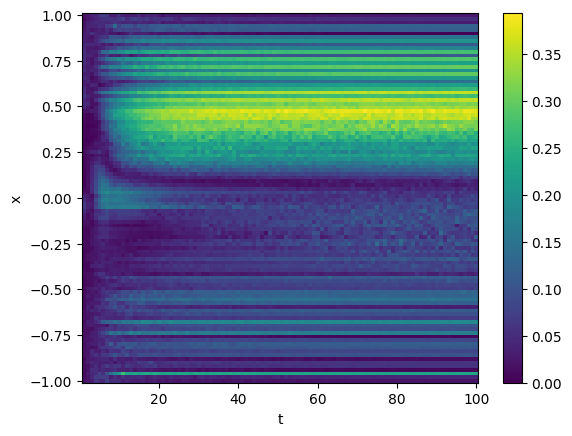

In [38]:

def xt_loss(x, t, rng_key):
    s_rng, n_rng = foundry.random.split(rng_key)
    y = schedule.sample(s_rng, partial(nn_denoiser, x), jnp.zeros(()))
    noised_y, _, _ = schedule.add_noise(n_rng, y, t)
    a = nw_denoiser(x, None, noised_y, t)
    a = schedule.denoised_from_output(noised_y, t, a)
    b = nn_denoiser(x, None, noised_y, t)
    b = schedule.denoised_from_output(noised_y, t, b)
    return jnp.mean(jnp.abs(a - b))

def xt_loss_multi(x, t, rng_key):
    rngs = foundry.random.split(rng_key, 16)
    losses = F.vmap(lambda r: xt_loss(x, t, r))(rngs)
    return jnp.mean(losses)

def x_loss(x, rng_key):
    rngs = foundry.random.split(rng_key, tree.axis_size(Ts, 0))
    losses = F.vmap(partial(xt_loss_multi, x))(Ts, rngs)
    return losses

@F.jit
def loss(rng_key):
    rngs = foundry.random.split(rng_key, tree.axis_size(xs, 0))
    losses = F.vmap(x_loss)(xs, rngs)
    return losses

xs = jnp.linspace(-1, 1, 100)
Ts = jnp.arange(1, schedule.num_steps + 1)

losses = loss(foundry.random.key(42))
c = plt.pcolormesh(Ts, xs, losses, cmap="viridis", vmin=0.)
plt.colorbar(c)
plt.xlabel("t")
plt.ylabel("x")
plt.show()